In [1]:
from multiprocessing import Pool
import os

import numpy as np
import matplotlib.pyplot as plt
import tifffile as tiff
import skimage as ski
from scipy.ndimage import zoom
%matplotlib inline 
%load_ext autoreload
%autoreload 2

In [9]:
from network_flow_tracker.utils.io import save_data, load_data
import network_flow_tracker.LFBFP as LFBFP
import network_flow_tracker.utils.vis as vis

In [ ]:
data_root_path = 'C:\\Data\\Lightfield\\Zhang2020'

process_data_root = os.path.join(data_root_path, 'processed_data')
info_fp = os.path.join(process_data_root, 'data_info.pickle')
update_info_Q = False

if not os.path.isfile(info_fp) or update_info_Q:
    data_info = {}
    data_info['frame_rate_Hz'] = 70
    data_info['voxel_size_um'] = np.array([2.5, 2, 2])
    data_info['target_voxel_size_um'] = 2
    data_info['bbox_mm'] = np.array([20, 52, 62])
    data_info['bbox_xx'] = np.array([80, 452, 462])
    data_info['bbox_ll'] = data_info['bbox_xx'] - data_info['bbox_mm']

    raw_data_root = os.path.join(data_root_path, 'raw_data')
    data_info['raw_data_folders'] = sorted([f for f in os.listdir(raw_data_root) if os.path.isdir(os.path.join(raw_data_root, f))])
    data_info['z_valid_range_um'] = [[int(fn.split('_')[0][1:]), int(fn.split('_')[1][:-2])] for fn in data_info['raw_data_folders']]
    data_info['num_z'] = len(data_info['raw_data_folders'])
    data_info['info_fp'] = info_fp
    data_info['raw_data_file'] = []
    data_info['num_files'] = []
    for fn in data_info['raw_data_folders']:
        fp = os.path.join(raw_data_root, fn)
        vol_list = sorted([f for f in os.listdir(fp) if f.endswith('.tif')])
        data_info['raw_data_file'].append(vol_list)
        data_info['num_files'].append(len(vol_list))
        print(f"Number of volume in the folder: {len(vol_list)}")

    save_data(data_info['info_fp'], data_info)
else:
    print("Load from existing file")
    data_info = load_data(info_fp)

lfp = LFBFP.LFBFProcessing(data_root_path, data_info)
target_zoom = data_info['voxel_size_um'] / data_info['target_voxel_size_um']

Load from existing file


In [11]:
data_info['z_valid_range_um']

[[0, 150], [100, 250], [200, 350], [300, 450], [400, 550], [500, 650]]

### Visualize single volume

In [ ]:
z_idx = 0
num_files = data_info['num_files'][z_idx]
z_folder_name = data_info['raw_data_folders'][z_idx]
lfp = LFBFP.LFBFProcessing(data_root_path, data_info)
t_idx = 0
test_data = lfp.load_and_preprocess_raw_data_to_match_mask(z_idx, t_idx) # (75, 400, 400), circular masked
raw_data_mips = vis.compute_three_view_mip(test_data)
f = vis.vis_mips(raw_data_mips, colorbarQ=True, cbar_label='Intensity', show_axes_Q=True, fig_title=f"{data_info['raw_data_folders'][z_idx]}, t = {t_idx} MIPs")

### Compute max intensity projection of the raw data

In [4]:
def compute_mip_t(data_root_path, data_info, z_idx, save_folder=None):
    mip_stack = None
    mean_stack = None
    m2_stack = None
    num_files = data_info['num_files'][z_idx]
    z_folder_name = data_info['raw_data_folders'][z_idx]
    lfp = LFBFP.LFBFProcessing(data_root_path, data_info)
    for t_idx in range(num_files):
        raw_fp = lfp.fp_raw_data(z_idx, t_idx)
        raw_data = tiff.imread(raw_fp)
        if mip_stack is None: 
            mip_stack = raw_data
            mean_stack = raw_data.astype(np.float32)
            m2_stack = raw_data.astype(np.float32) ** 2
        else:
            mip_stack = np.maximum(mip_stack, raw_data)
            mean_stack += raw_data.astype(np.float32)
            m2_stack += raw_data.astype(np.float32) ** 2
        if t_idx % 50 == 0:
            print(f"Finish processing {t_idx/num_files} files")
    mean_stack /= num_files
    m2_stack /= num_files
    std_stack = np.sqrt(m2_stack - mean_stack ** 2) 
    if save_folder is not None: 
        fp_raw_mip = os.path.join(save_folder, f"{z_folder_name}_mip.tif")
        save_data(fp_raw_mip, mip_stack)
        fp_mean_mip = os.path.join(save_folder, f"{z_folder_name}_mean.tif")
        save_data(fp_mean_mip, mean_stack)
        fp_std_mip = os.path.join(save_folder, f"{z_folder_name}_std.tif")
        save_data(fp_std_mip, std_stack)
    return mip_stack

In [ ]:
fp_full_mip_folder = os.path.join(process_data_root, 'vol_t_stat', 'raw')
num_folder = len(data_info['raw_data_folders'])
args = [(data_root_path, data_info, z_idx, fp_full_mip_folder) for z_idx in range(num_folder)]
with Pool(int(num_folder)) as p: 
    result = p.starmap(compute_mip_t, args)
print("Finish computing all the task")

### Compute Bounding box

In [ ]:
mip_folder = os.path.join(process_data_root, 'mip')
mip_list = []
for fn in data_info['raw_data_folders']:
    mip_list.append(load_data(os.path.join(mip_folder, 'raw', f"{fn}_raw.tif")))

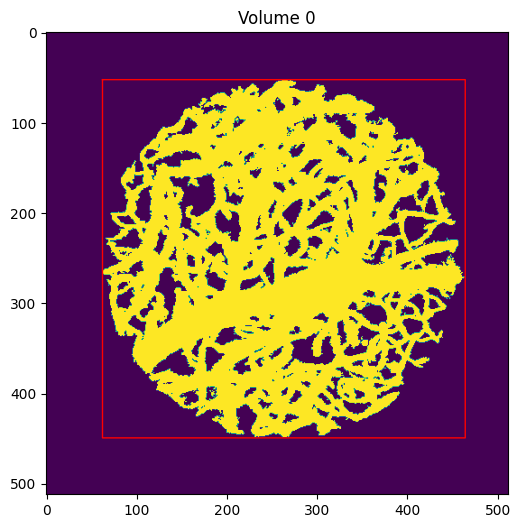

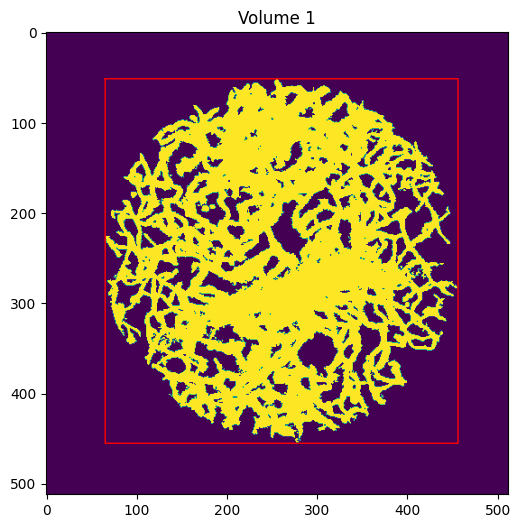

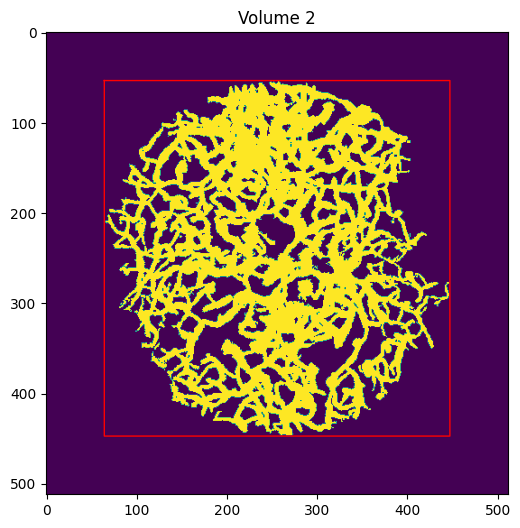

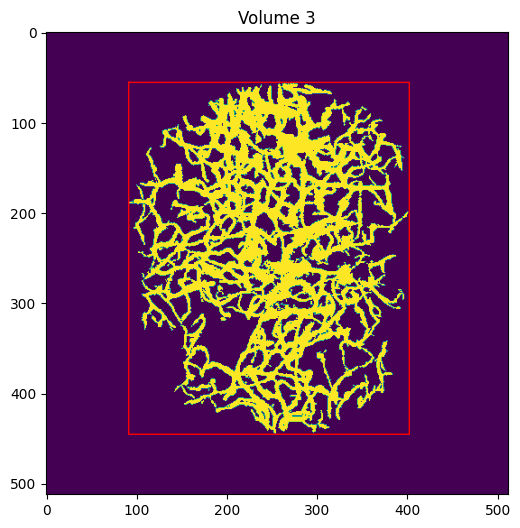

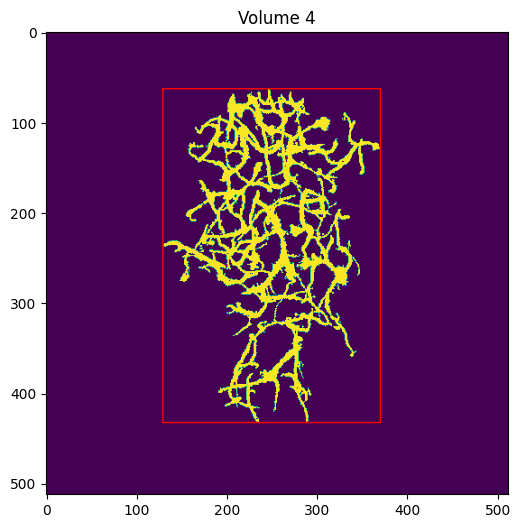

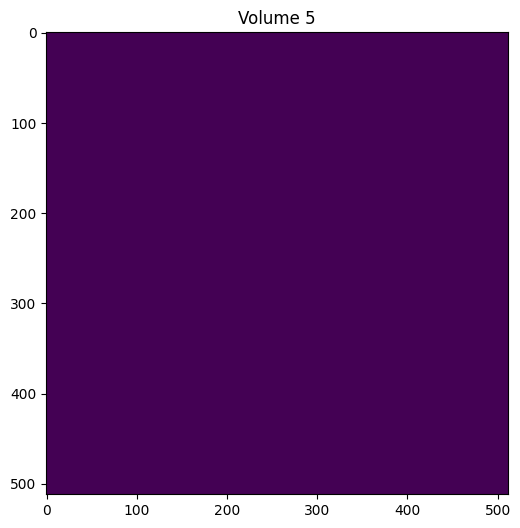

In [6]:
# Compute bounding box
vol_bbox = []
for i_vol in range(len(mip_list)):
    tmp_mip2d = np.max(mip_list[i_vol][20 : 80], axis=0)
    tmp_mask = tmp_mip2d > 5e2
    tmp_lm = ski.measure.label(tmp_mask)
    tmp_cc_prop = ski.measure.regionprops(tmp_lm)
    tmp_cc_num_pxl = np.array([p.num_pixels for p in tmp_cc_prop])
    tmp_is_large_cc_Q = tmp_cc_num_pxl > (np.sum(tmp_cc_num_pxl) * 0.3)
    large_cc_label = np.ravel_multi_index(np.where(tmp_is_large_cc_Q), tmp_is_large_cc_Q.shape) 
    tmp_large_cc_mask = np.zeros(tmp_lm.shape, dtype=bool)
    tmp_large_cc_bbox = []
    for i in list(large_cc_label):
        tmp_large_cc_mask |= (tmp_lm == (i + 1))
        tmp_large_cc_bbox.append(tmp_cc_prop[i].bbox)
    # Find the bounding box 
    tmp_lc_x, tmp_lc_y = np.nonzero(tmp_large_cc_mask)
    f, a = plt.subplots(figsize=(8, 6))
    a.imshow(tmp_large_cc_mask) 
    for bbox in tmp_large_cc_bbox:
        rr, cc = ski.draw.rectangle_perimeter((bbox[0], bbox[1]), end=(bbox[2] - 1, bbox[3] - 1), shape=tmp_large_cc_mask.shape)
        a.plot(cc, rr, 'r', linewidth=1)
    a.set_title(f"Volume {i_vol}")
    plt.show()
    vol_bbox.append(tmp_large_cc_bbox)

In [7]:
vol_bbox = np.array([i[0] for i in vol_bbox if i])
print(vol_bbox)
overall_bbox = np.concatenate((np.min(vol_bbox[:, 0:2], axis=0), np.max(vol_bbox[:, 2:4], axis=0)))
obbox_ctr = (overall_bbox[0:2] + overall_bbox[2:4]) / 2
obbox_r = (overall_bbox[2:4] - overall_bbox[0:2]) / 2
print("Overall bounding box", overall_bbox)
print(f"Center {obbox_ctr}, radius {obbox_r}")


[[ 53  63 449 464]
 [ 52  66 455 456]
 [ 54  65 447 447]
 [ 56  92 445 402]
 [ 63 130 432 370]]
Overall bounding box [ 52  63 455 464]
Center [253.5 263.5], radius [201.5 200.5]


In [28]:
data_info['bbox_mm'] = np.array([20, 52, 62])
data_info['bbox_xx'] = np.array([80, 452, 462])
save_data(data_info['info_fp'], data_info)

In [20]:
valid_vol = [v[data_info['bbox_mm'][0] : data_info['bbox_xx'][0], 
               data_info['bbox_mm'][1] : data_info['bbox_xx'][1],
               data_info['bbox_mm'][2] : data_info['bbox_xx'][2]] for v in mip_list]
folders_z_0 = [z[0] for z in data_info['z_valid_range_um']]
total_vol_size = (int(data_info['z_valid_range_um'][-1][-1] / 2.5), 400, 400)

In [21]:
# Direct stitching using max intensity projection
mip_s = np.zeros(total_vol_size, dtype=np.uint16)
for i, tmp_vol in enumerate(valid_vol):
    tmp_z_0 = int(folders_z_0[i] / 2.5)
    tmp_z_1 = tmp_z_0 + 60 
    if i == 0:
        mip_s[tmp_z_0 : tmp_z_1] = tmp_vol
    else:
        mip_s[tmp_z_0 : tmp_z_1] = np.maximum(mip_s[tmp_z_0 : tmp_z_1], tmp_vol)

Text(0.5, 0, 'X (2 um)')

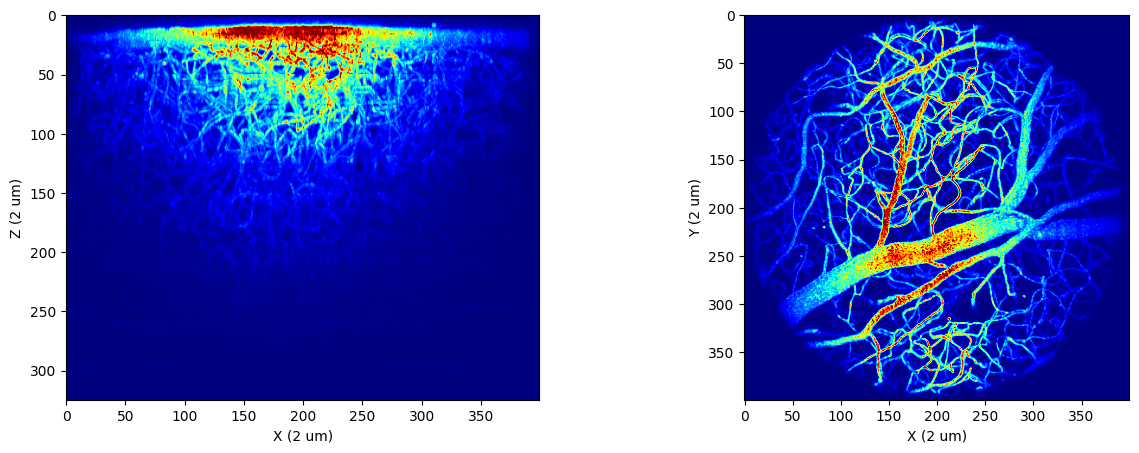

In [ ]:
mip_s_i = zoom(mip_s, target_zoom, order=1)
f, a = plt.subplots(1, 2, figsize=(15, 5))
a[0].imshow(np.max(mip_s_i, axis=1) ** 1/3, cmap='jet')
a[0].set_ylabel("Z (2 um)")
a[0].set_xlabel("X (2 um)")
a[1].imshow(np.max(mip_s_i, axis=0), cmap='jet')
a[1].set_ylabel("Y (2 um)")
a[1].set_xlabel("X (2 um)")

In [ ]:
# Try translation-based registration
from network_flow_tracker.utils.registration import TranslationRegSP
import scipy as sp

In [12]:
pairwise_t_vec = [np.array([0, 0, 0])]
normal_tran_vec = np.array([-20, 0, 0])
for i in range(len(mip_list)-1):
    tran_vec = TranslationRegSP(valid_vol[i], valid_vol[i+1]) - normal_tran_vec
    pairwise_t_vec.append(tran_vec)
print(pairwise_t_vec)

[array([0, 0, 0]), array([-3.,  2.,  0.]), array([-2.,  1.,  0.]), array([-1.,  2.,  0.]), array([-2.,  1.,  0.]), array([20.,  0.,  0.])]


In [ ]:
pairwise_t_vec[-1][0] = 0
cum_t_vec = np.stack(pairwise_t_vec)
cum_t_vec[-1, 0] = 0
cum_t_vec = np.cumsum(cum_t_vec, axis=0)
print(cum_t_vec)
data_info['t_vec_pairwise'] = pairwise_t_vec
data_info['t_vec_cum'] = cum_t_vec
save_data(data_info['info_fp'], data_info)

[[ 0.  0.  0.]
 [-3.  2.  0.]
 [-5.  3.  0.]
 [-6.  5.  0.]
 [-8.  6.  0.]
 [-8.  6.  0.]]


In [15]:
# Transform registered volumes
reg_im = []
for i, tmp_vec in enumerate(list(cum_t_vec)):
    im_reg = valid_vol[i].copy()
    if np.any(tmp_vec):
        im_reg = sp.ndimage.shift(im_reg, tmp_vec, order=1)
    reg_im.append(im_reg)

In [18]:
# Assume uniform spacing here
folders_z_0_idx = np.int16(np.array(folders_z_0) / 2.5) 
stack_spacing = folders_z_0_idx[1] - folders_z_0_idx[0]
size_z = data_info['bbox_ll'][0]
stack_overlap = size_z - stack_spacing
z_half_overlap = int(stack_overlap / 2)

In [22]:
# Use the lower half of the overlapping volume for max projection 
# It seems that reconstruction artefact extended beyond the first 20 section
mip_st = np.zeros(total_vol_size, dtype=np.uint16)
for i, tmp_vol in enumerate(reg_im):
    tmp_z_0 = folders_z_0_idx[i]
    tmp_z_1 = tmp_z_0 + 60 
    if i == 0:
        mip_st[tmp_z_0 : tmp_z_1] = tmp_vol
    else:
        tmp_z_0 = tmp_z_0 + z_half_overlap
        mip_st[tmp_z_0 : tmp_z_1] = np.maximum(mip_st[tmp_z_0 : tmp_z_1], tmp_vol[z_half_overlap:])

In [ ]:
tmp_tif_fp = os.path.join(process_data_root, 'mip', f"mip_stitched_r.tif")
save_data(tmp_tif_fp, mip_st)
# Resize to 2 um isotropic resolution
mip_st_i = zoom(mip_st, target_zoom, order=1)
tmp_tif_fp = os.path.join(process_data_root, 'mip', f"mip_stitched_ri.tif")
save_data(tmp_tif_fp, mip_st_i)

Text(0.5, 0, 'X (2 um)')

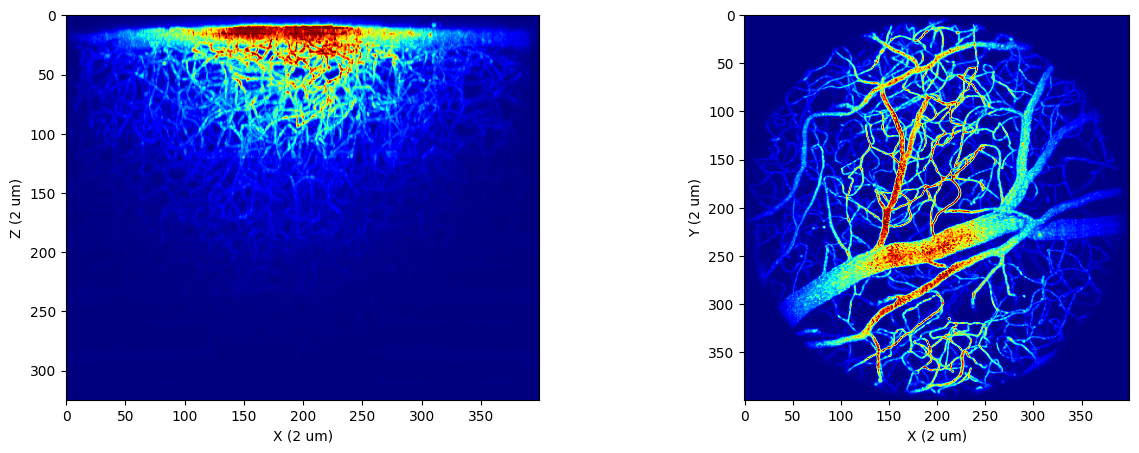

In [ ]:
f, a = plt.subplots(1, 2, figsize=(15, 5))
a[0].imshow(np.max(mip_st_i, axis=1) ** 1/3, cmap='jet')
a[0].set_ylabel("Z (2 um)")
a[0].set_xlabel("X (2 um)")
a[1].imshow(np.max(mip_st_i, axis=0), cmap='jet')
a[1].set_ylabel("Y (2 um)")
a[1].set_xlabel("X (2 um)")

In [ ]:
# Write registered MIP volume
mm_r = (data_info['bbox_mm'] - data_info['t_vec_cum']).astype(np.int16)
xx_r = (data_info['bbox_xx'] - data_info['t_vec_cum']).astype(np.int16)

mip_vol_r = [v[mm_r[i][0] : xx_r[i][0], 
               mm_r[i][1] : xx_r[i][1],
               mm_r[i][2] : xx_r[i][2]] for i, v in enumerate(mip_list)]

In [ ]:
data_info['bbox_mm_r'] = mm_r
data_info['bbox_xx_r'] = xx_r


In [44]:
for i, vol in enumerate(mip_vol_r):
    tmp_fp = os.path.join(process_data_root, 'mip', 'reg', f"{data_info['raw_data_folders'][i]}_reg.tif")
    save_data(tmp_fp, vol)
    print(f"Finish writing registered MIP to {tmp_fp}")


Finish writing registered MIP to /scratch/Vessel/Lightfield/Zhang2020/processed_data/mip/reg/z0_150um_reg.tif
Finish writing registered MIP to /scratch/Vessel/Lightfield/Zhang2020/processed_data/mip/reg/z100_250um_reg.tif
Finish writing registered MIP to /scratch/Vessel/Lightfield/Zhang2020/processed_data/mip/reg/z200_350um_reg.tif
Finish writing registered MIP to /scratch/Vessel/Lightfield/Zhang2020/processed_data/mip/reg/z300_450um_reg.tif
Finish writing registered MIP to /scratch/Vessel/Lightfield/Zhang2020/processed_data/mip/reg/z400_550um_reg.tif
Finish writing registered MIP to /scratch/Vessel/Lightfield/Zhang2020/processed_data/mip/reg/z500_650um_reg.tif


In [ ]:
# Check registration 
mip_r = np.zeros(total_vol_size, dtype=np.uint16)
for i, tmp_vol in enumerate(mip_vol_r):
    tmp_z_0 = folders_z_0_idx[i]
    tmp_z_1 = tmp_z_0 + 60 
    if i == 0:
        mip_r[tmp_z_0 : tmp_z_1] = tmp_vol
    else:
        tmp_z_0 = tmp_z_0 + z_half_overlap
        mip_r[tmp_z_0 : tmp_z_1] = np.maximum(mip_r[tmp_z_0 : tmp_z_1], tmp_vol[z_half_overlap:])

Text(0.5, 0, 'X (2 um)')

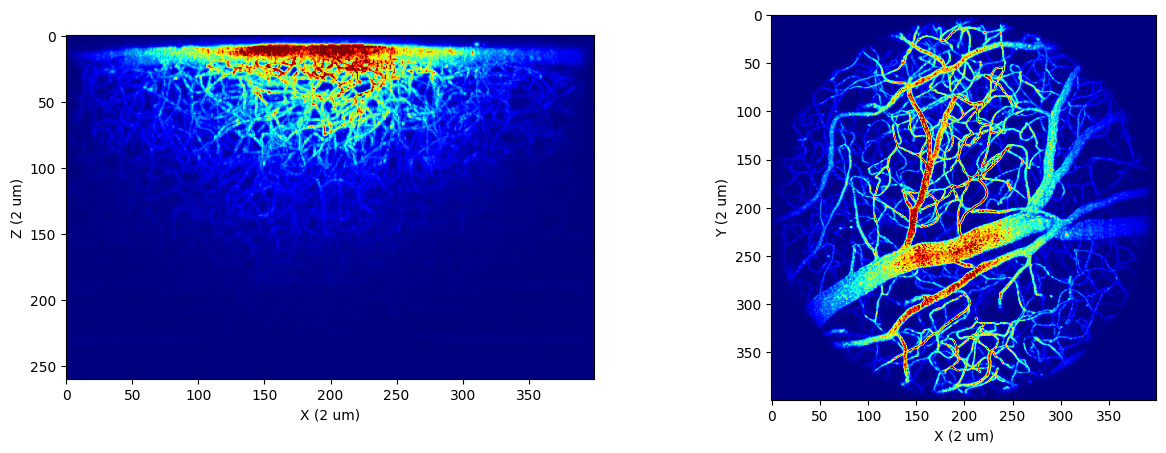

In [38]:
f, a = plt.subplots(1, 2, figsize=(15, 5))
a[0].imshow(np.max(mip_r, axis=1) ** 1/3, cmap='jet')
a[0].set_ylabel("Z (2 um)")
a[0].set_xlabel("X (2 um)")
a[1].imshow(np.max(mip_r, axis=0), cmap='jet')
a[1].set_ylabel("Y (2 um)")
a[1].set_xlabel("X (2 um)")